In [1]:
# Firstly we will need some dependecies
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
ds=tfds.load('fashion_mnist',split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.ZYB6MA_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.ZYB6MA_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
# lets see the numpy array of the first image
ds.as_numpy_iterator().next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

# **Visualize image and build data pipeline**

In [9]:
import numpy as np

In [10]:
dataiterator=ds.as_numpy_iterator()

In [11]:
# Getting the data out of the pipeline
# see many data
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

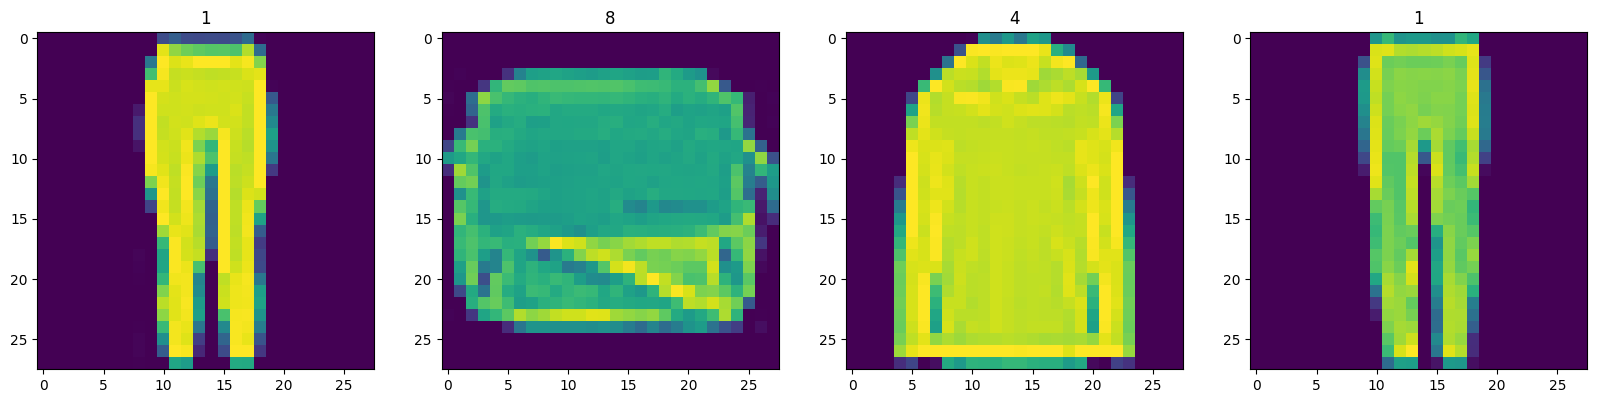

In [12]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for i in range(4):
  batch=dataiterator.next()
  ax[i].imshow(batch['image'])
  ax[i].title.set_text(batch['label'])

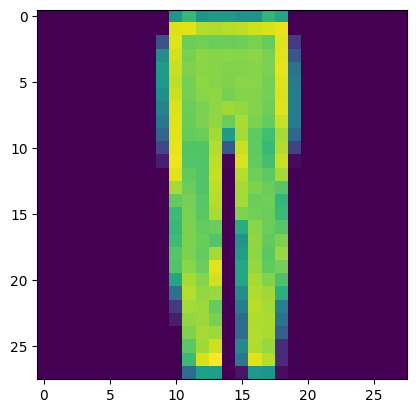

In [14]:
plt.imshow(batch['image'])

In [13]:
print(batch['image'].shape)
# we can sqeeze dimension
print(np.squeeze(batch['image']).shape)

(28, 28, 1)
(28, 28)


# **Data Preprocessing**

In [15]:
def scale_image(data):
  # because it unsupervised learning we just need the image only without the label
  image=data['image']
  return image/255

**1. What is a Data Pipeline?**

In machine learning, a data pipeline is the sequence of steps you use to get your raw dataset from storage → ready for the model.


**2.What prefetch is doing??**

If loading is slower than training, the GPU will sit idle waiting for the next batch.

The number you pass to prefetch() is the maximum number of batches to keep ready in memory.


In [16]:
# macashbap  intialization for the steps
ds=tfds.load('fashion_mnist',split='train')
ds=ds.map(scale_image)
ds=ds.cache()
ds=ds.shuffle(60000)
# 128 sample in each batch
ds=ds.batch(128)
# prepare 64 batch to keep ready in memory
ds=ds.prefetch(64)

In [17]:
# 128 sample in each batch
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# **YAAAAY!!! Our time to build The neural networks**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

# **Build generator**

why 7x7x128???

We want 7×7×128 = 6272 neurons in this layer.

Each neuron is connected to all 128 inputs.

So every output neuron gets 128 weights (one per input) + 1 bias.
That’s 6272 numbers still in a straight line, no 2D image yet.
Here’s what each dimension means:

7 (height) = 7 rows

7 (width) = 7 columns

128 (channels) = at each grid cell, we store 128 values

In [19]:
def build_generator():
  model=Sequential()
  # First block which will take the random input
  # making 1 dense fully connected layer take 128 value random noise
  model.add(Dense(7*7*128,input_dim=128))
  # prevent dying RELU
  model.add(LeakyReLU(0.2))
  # beginning of an image with a ton layer but we will end with 28*28*1
  model.add(Reshape((7,7,128)))

  # Then second block we need to upsample the first block's output
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

    # we can do that in third block but that wil not make our generator sophisticated to generate images
  # model.add(UpSampling2D())
  # model.add(Conv2D(1,5,padding='same'))
  # model.add(LeakyReLU(0.2))

  # Third blocks we are trying to add some layers to make our generator more sophisticated
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # fourth block time for downsampling as we reach 28*28
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # fifth block another down sampling
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Lets start to make a final layer
  model.add(Conv2D(1,4,activation='sigmoid',padding='same'))


  return model

In [20]:
generator=build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

Lets test our generator

np.random.randn(4,128,1)

It generates random numbers from a standard normal distribution:

Mean = 0

Standard deviation = 1

Most numbers are around -1 to 1


(batch_size, features, channels)


In [21]:
img=generator.predict(np.random.randn(4,128,1))
img.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(4, 28, 28, 1)

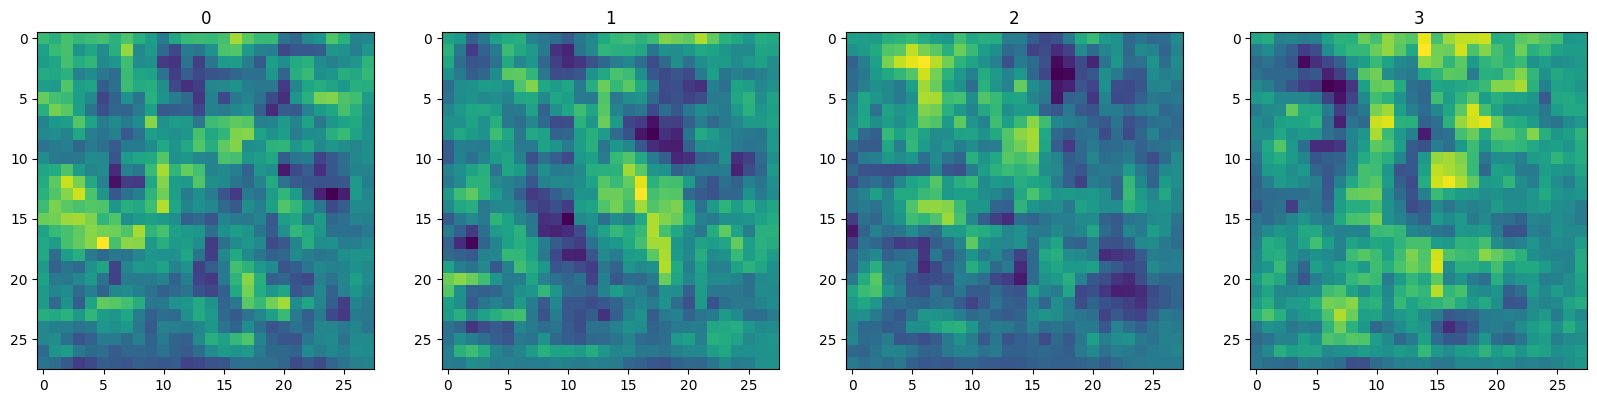

In [22]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for i,im in enumerate(img):
  ax[i].imshow(im)
  ax[i].title.set_text(i)

# **Build discriminator**

In [36]:
def build_discriminator():
  model=Sequential()

  # first conv layer
  model.add(Conv2D(32,5,input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  # That is the strength of the droput dropout 40% of the data
  model.add(Dropout(0.4))

  # second conv layer
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # third conv layer
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # fourth layer
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # next we have to flatten and pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))



  return model

In [37]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

Important note!!!!

typically when you pass image to deep neural network it expect the batch number to be first and if it it a single image do that
np.expand_dims(img,0)

In [38]:
discriminator.predict(img)
# so it print for all the 4 generated image to be 50% real and 50% fake


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


array([[0.49969643],
       [0.49973667],
       [0.49973613],
       [0.49980336]], dtype=float32)

In [39]:
# for the first image only
discriminator.predict(np.expand_dims(img[0],0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


array([[0.49969643]], dtype=float32)

# **Training LOOP**

In [40]:
# We need to find a balance of the speed of training generator and speed of training discriminator and one way to do that that we inject
# random noise to the output of discriminator to slow it down a little bit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [41]:
g_opt=Adam(learning_rate=0.0001)
# trying to make the discriminator learning slower
d_opt=Adam(learning_rate=0.00001)
g_loss=BinaryCrossentropy()
d_loss=BinaryCrossentropy()

In [42]:
from tensorflow.keras.models import Model

In [43]:
# The main key functions here init ,compile then train step
class FashionGAN(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    # take all these extra arguments
    super().__init__(*args,**kwargs)
    self.generator=generator
    self.discriminator=discriminator


  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    # we need to take also the base compile func from the parent
    super().compile(*args,**kwargs)
    self.g_opt=g_opt
    self.d_opt=d_opt
    self.g_loss=g_loss
    self.d_loss=d_loss

  def train_step(self,batch):
    # get the data
    real_images=batch
    fake_images=self.generator(tf.random.normal((128,128,1)),training=False) # that enter as a input dims to the neural network

# Train the discriminator
    # pass real and fake images to the discriminator
    # we need to calculate to our gradient
    with tf.GradientTape() as d_tape:
      yhat_real=self.discriminator(real_images,training=True)
      yhat_fake=self.discriminator(fake_images,training=True)
      yhat_realfake=tf.concat([yhat_real,yhat_fake],axis=0)

      # create labels for the real and fake images
      y_realfake=tf.concat([tf.ones_like(yhat_real),tf.zeros_like(yhat_fake)],axis=0)
      # add some noise to the true outputs after testing we found it good practise to add 0.15 to fake and minus from the real then that noise to the true outputs
      noise_real=-0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake=0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake+=tf.concat([noise_real,noise_fake],axis=0)
      # calculate loss Binary cross entropy
      total_d_loss=self.d_loss(y_realfake,yhat_realfake)

    # apply back propagation nn gradient of weights wrt L
    dgrad=d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
    # then we to apply our gradients |zip because we want to apply gradient wrt to those trainable variables
    self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

# Train the generator
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images=self.generator(tf.random.normal((128,128,1)),training=True)
      # Create predicted label
      predicted_labels=self.discriminator(gen_images,training=False) #now we dont train it but we want its output of the discriminator
      # calculate loss
      # we want to fool the discriminator
      # the first part must be true label which is fake but we want to fool the discriminator so the label must be real which is one
      total_g_loss=self.g_loss(tf.ones_like(predicted_labels),predicted_labels)
    ggrad=g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))


    return {'discriminator_loss ':total_d_loss,' Generator_loss ':total_g_loss}



In [44]:
gen_fashion=FashionGAN(generator,discriminator)


In [45]:
gen_fashion.compile(g_opt,d_opt,g_loss,d_loss)

# **Build custom Callback**

In [46]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [47]:
# we can use that class ton times for GANs
class ModelMonitor(Callback):
  # we will pass # of images we generate and latent dims (noise)
  def __init__(self,num_img=3,latent_dim=128):
    self.num_img=num_img
    self.latent_dim=latent_dim

  def on_epoch_end(self,epoch,logs=None):
    random_latent_vector=tf.random.uniform((self.num_img,self.latent_dim,1))
    generated_images=self.model.generator(random_latent_vector)
    # rescaling pixel values from the range [0, 1] back to [0, 255]
    generated_images*=255
    generated_images.numpy()
    for i in range(self.num_img):
      img=array_to_img(generated_images[i])
      # save images to the folder images
      img.save(os.path.join('images',f'Generated_img_{epoch}_{i}.png'))



# **Begin our Training**

In [71]:
history=gen_fashion.fit(ds,epochs=150,callbacks=[ModelMonitor()])

Epoch 1/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step -  Generator_loss : 0.6110 - discriminator_loss : 0.6935
Epoch 2/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step -  Generator_loss : 0.6511 - discriminator_loss : 0.6951
Epoch 3/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step -  Generator_loss : 0.6450 - discriminator_loss : 0.6876
Epoch 4/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step -  Generator_loss : 0.6802 - discriminator_loss : 0.6470
Epoch 5/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step -  Generator_loss : 0.6112 - discriminator_loss : 0.6823
Epoch 6/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step -  Generator_loss : 0.6146 - discriminator_loss : 0.6794
Epoch 7/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step -  Generator_loss : 0.5987 - discriminator_loss : 0.6582
Epoch 8/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 150ms/step -  Generator_loss : 0.6152 - discriminator_loss : 0.6393
Epoch 9/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step -  Generator_loss : 0.5389 - discriminat

In [72]:
history.history

{' Generator_loss ': [0.6404249668121338,
  0.6151458621025085,
  0.6215928792953491,
  0.6471412777900696,
  0.5465338230133057,
  0.6410056352615356,
  0.5118712782859802,
  0.4021720588207245,
  0.6407727599143982,
  0.6376327276229858,
  0.4990774989128113,
  0.5576834678649902,
  0.6371504068374634,
  0.573340654373169,
  0.5939192175865173,
  0.49267616868019104,
  0.7489916086196899,
  0.5717037320137024,
  0.5831624269485474,
  0.6399447917938232,
  0.5911108255386353,
  0.770422101020813,
  0.632060170173645,
  0.6086578369140625,
  0.584498405456543,
  0.7011081576347351,
  0.5606729388237,
  0.6263796091079712,
  0.6524677872657776,
  0.6065754890441895,
  0.859220564365387,
  0.6168270707130432,
  0.5474472045898438,
  0.6308470964431763,
  0.6051651239395142,
  0.5782991647720337,
  0.6035500764846802,
  0.5933952331542969,
  0.5369440317153931,
  1.5231777429580688,
  1.3677012920379639,
  0.5662685632705688,
  0.7631566524505615,
  0.5873445272445679,
  0.517979145050048

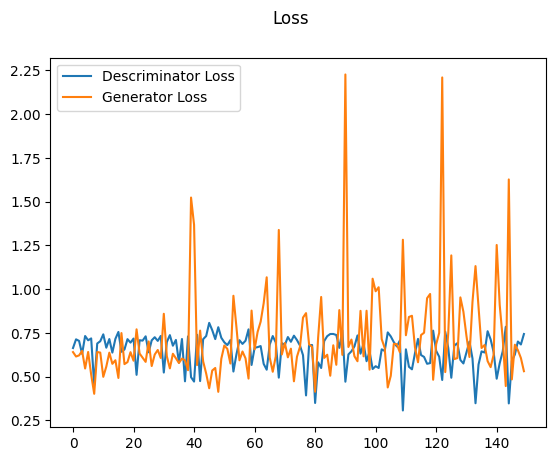

In [73]:
# Now lets plot our evaluation
plt.suptitle('Loss')
plt.plot(history.history['discriminator_loss '],label='Descriminator Loss')
plt.plot(history.history[' Generator_loss '],label='Generator Loss')
plt.legend()
plt.show()

# ***Finally Show the Generated images PHEW!!!!***

In [74]:
# Generate images
imgs=generator.predict(tf.random.normal((16,128,1)))
imgs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


array([[[[3.76741197e-17],
         [1.26426245e-16],
         [1.42033331e-14],
         ...,
         [4.75138333e-03],
         [4.01928555e-03],
         [1.05513111e-02]],

        [[4.43571546e-15],
         [1.03307080e-07],
         [2.55592636e-09],
         ...,
         [2.35310989e-04],
         [2.29528378e-04],
         [2.17995467e-03]],

        [[1.25033091e-14],
         [6.52813181e-09],
         [1.61544597e-10],
         ...,
         [3.42267849e-05],
         [3.71643364e-05],
         [2.93060584e-04]],

        ...,

        [[2.78203538e-06],
         [1.82221868e-07],
         [4.98525532e-09],
         ...,
         [4.44381976e-06],
         [1.43526750e-05],
         [6.30756025e-04]],

        [[2.12127328e-04],
         [1.16602087e-05],
         [2.31498490e-07],
         ...,
         [2.38850043e-06],
         [8.19689376e-06],
         [2.75110913e-04]],

        [[8.06473009e-03],
         [4.32310953e-05],
         [1.42885960e-06],
         ...,
 

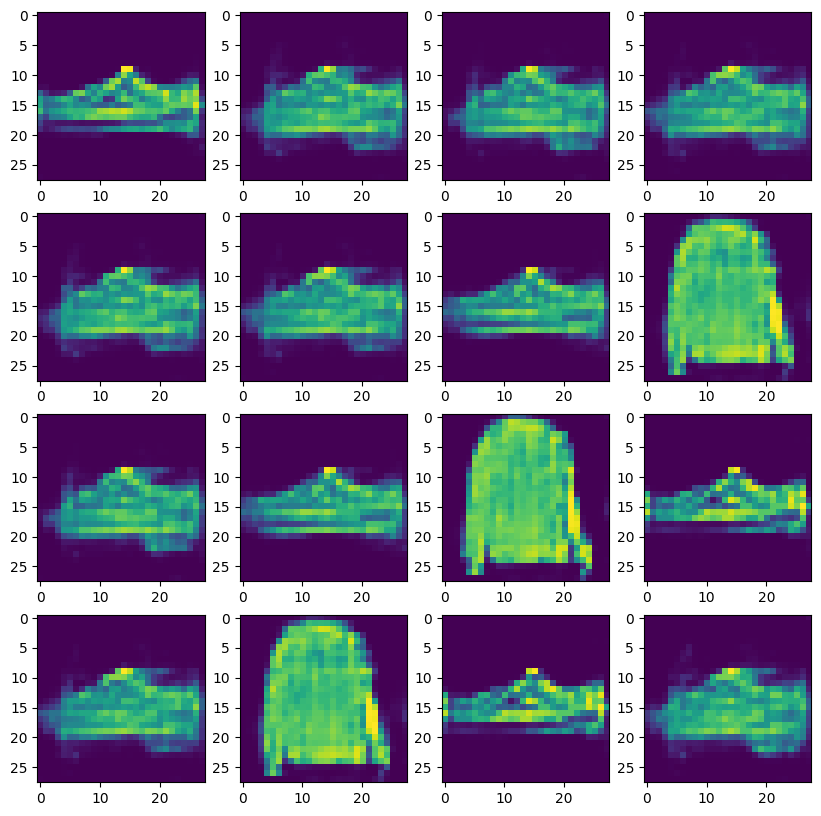

In [77]:
fig,ax=plt.subplots(ncols=4,nrows=4,figsize=(10,10))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[((r+1)*(c+1)-1)])

# if we increase we will get a better results

In [76]:
# To save
generator.save('generator.h5')
discriminator.save('Discriminator.h5')
# if want to get it
# generator.load_weights(os.path.join('folder_name','the name of generator'))